In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from sklearn.preprocessing import MinMaxScaler

Using device: cuda


In [2]:
class TSDataset(Dataset):
    def __init__(self, data, seq_length=30, forecast_horizon = 7):
        self.data = data
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.data) - self.seq_length - self.forecast_horizon + 1
    
    def __getitem__(self, index):
        x = self.data[index : index + self.seq_length]
        y = self.data[index + self.seq_length : index + self.seq_length + self.forecast_horizon]
        return (torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32))

In [3]:
ts_dataset = pd.read_csv("daily-minimum-temperatures-in-me.csv")
ts_dataset

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8
...,...,...
3645,12/27/1990,14.0
3646,12/28/1990,13.6
3647,12/29/1990,13.5
3648,12/30/1990,15.7


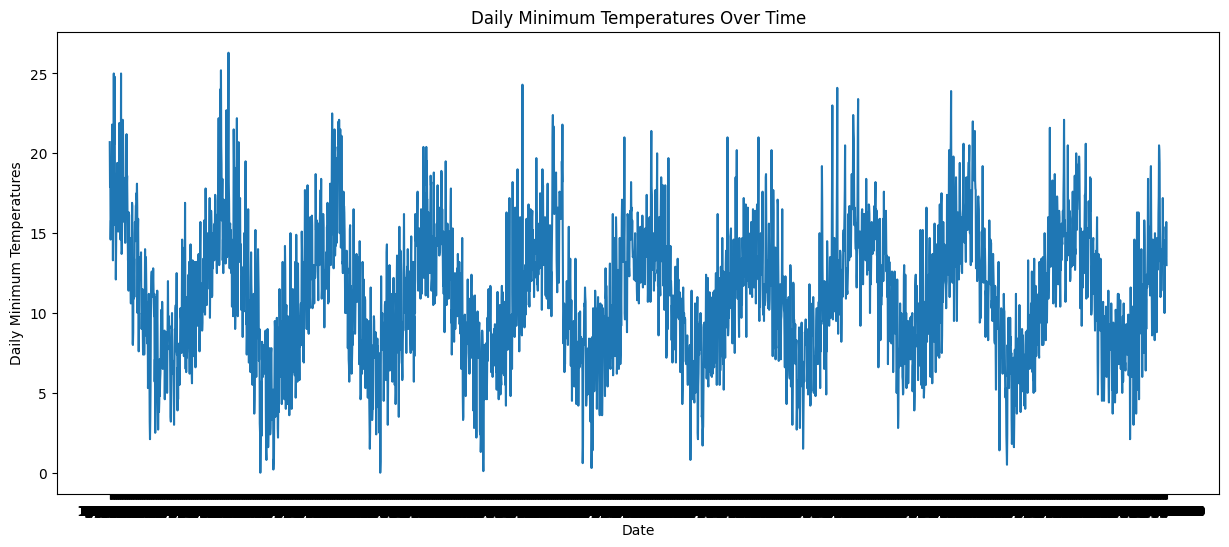

In [4]:
plt.figure(figsize=(15,6))
plt.plot(ts_dataset['Date'], ts_dataset['Daily minimum temperatures'])
plt.xlabel('Date')
plt.ylabel('Daily Minimum Temperatures')
plt.title('Daily Minimum Temperatures Over Time')
plt.show()

In [5]:
temps = ts_dataset['Daily minimum temperatures'].values

min_max_scaler = MinMaxScaler()
temps = min_max_scaler.fit_transform(temps.reshape(-1, 1)).flatten()

train_size = int(len(temps) * 0.8)
train_temps = temps[:train_size]
test_temps = temps[train_size:]

In [6]:
train_dataset = TSDataset(train_temps, seq_length=30, forecast_horizon=7)
test_dataset = TSDataset(test_temps, seq_length=30, forecast_horizon=7)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=4, output_size=7):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  
        out = self.fc(out)
        return out

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=4, output_size=7):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [9]:
model1 = RNNModel().to(device)
criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)


In [10]:
epochs = 2000
best_model_loss = float('inf')
best_model_weights = None
patience = 5
patience_counter = 0

train_loss_list = []
val_loss_list = []
rmse_error_list = []

for epoch in range(epochs):

    model1.train()

    train_loss = 0.0
    total_train_samples = 0

    for inputs, targets in train_loader:
        optimizer1.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model1(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer1.step()

        train_loss += loss.item() * targets.numel()
        total_train_samples += targets.numel()


    avg_train_loss = train_loss / total_train_samples
    train_loss_list.append(avg_train_loss)


    model1.eval()
    val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model1(inputs)

            loss = criterion(outputs, targets)

            val_loss += loss.item() * targets.numel()
            total_val_samples += targets.numel()

    avg_val_loss = val_loss / total_val_samples
    val_loss_list.append(avg_val_loss)

    val_rmse = np.sqrt(avg_val_loss)
    rmse_error_list.append(val_rmse)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val RMSE: {val_rmse:.6f}")


        

Epoch [1/2000], Train Loss: 0.144613, Val Loss: 0.055473, Val RMSE: 0.235527
Epoch [2/2000], Train Loss: 0.027531, Val Loss: 0.022372, Val RMSE: 0.149574
Epoch [3/2000], Train Loss: 0.022127, Val Loss: 0.019000, Val RMSE: 0.137842
Epoch [4/2000], Train Loss: 0.017884, Val Loss: 0.011573, Val RMSE: 0.107580
Epoch [5/2000], Train Loss: 0.015376, Val Loss: 0.011124, Val RMSE: 0.105473
Epoch [6/2000], Train Loss: 0.014838, Val Loss: 0.011135, Val RMSE: 0.105524
Epoch [7/2000], Train Loss: 0.014513, Val Loss: 0.010868, Val RMSE: 0.104251
Epoch [8/2000], Train Loss: 0.014224, Val Loss: 0.010857, Val RMSE: 0.104197
Epoch [9/2000], Train Loss: 0.013954, Val Loss: 0.011144, Val RMSE: 0.105564
Epoch [10/2000], Train Loss: 0.013732, Val Loss: 0.010770, Val RMSE: 0.103776
Epoch [11/2000], Train Loss: 0.013784, Val Loss: 0.010724, Val RMSE: 0.103558
Epoch [12/2000], Train Loss: 0.013536, Val Loss: 0.011272, Val RMSE: 0.106171
Epoch [13/2000], Train Loss: 0.013494, Val Loss: 0.010752, Val RMSE: 0.10

In [11]:
model1.load_state_dict(best_model_weights)
model1.to(device)
model1.eval()

test_loss = 0.0
total_test_samples = 0

actual_temps = []
predicted_temps = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model1(inputs)

        loss = criterion(outputs, targets)

        test_loss += loss.item() * targets.numel()
        total_test_samples += targets.numel()

        actual_temps.append(targets.cpu().numpy())
        predicted_temps.append(outputs.cpu().numpy())


rnn_test_mse = test_loss / total_test_samples
rnn_test_rmse = np.sqrt(rnn_test_mse)

actual_temps = np.concatenate(actual_temps, axis=0)
predicted_temps = np.concatenate(predicted_temps, axis=0)

rnn_test_mae = np.mean(np.abs(actual_temps - predicted_temps))
rnn_test_mape = np.mean(np.abs((actual_temps - predicted_temps) / actual_temps + 1e-8)) * 100


print(f"Test MSE: {rnn_test_mse:.6f}")
print(f"Test RMSE: {rnn_test_rmse:.6f}")
print(f"Test MAE: {rnn_test_mae:.6f}")
print(f"Test MAPE: {rnn_test_mape:.6f}%")

Test MSE: 0.010671
Test RMSE: 0.103299
Test MAE: 0.079920
Test MAPE: 27.495432%


In [12]:
model2 = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

In [13]:
epochs = 2000
best_model_loss = float('inf')
best_model_weights = None
patience = 5
patience_counter = 0

train_loss_list = []
val_loss_list = []
rmse_error_list = []

for epoch in range(epochs):

    model2.train()

    train_loss = 0.0
    total_train_samples = 0

    for inputs, targets in train_loader:
        optimizer2.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model2(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer2.step()

        train_loss += loss.item() * targets.numel()
        total_train_samples += targets.numel()


    avg_train_loss = train_loss / total_train_samples
    train_loss_list.append(avg_train_loss)


    model2.eval()
    val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model2(inputs)

            loss = criterion(outputs, targets)

            val_loss += loss.item() * targets.numel()
            total_val_samples += targets.numel()

    avg_val_loss = val_loss / total_val_samples
    val_loss_list.append(avg_val_loss)

    val_rmse = np.sqrt(avg_val_loss)
    rmse_error_list.append(val_rmse)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val RMSE: {val_rmse:.6f}")


        

Epoch [1/2000], Train Loss: 0.111985, Val Loss: 0.029770, Val RMSE: 0.172541
Epoch [2/2000], Train Loss: 0.023332, Val Loss: 0.022603, Val RMSE: 0.150343
Epoch [3/2000], Train Loss: 0.021710, Val Loss: 0.019502, Val RMSE: 0.139651
Epoch [4/2000], Train Loss: 0.016456, Val Loss: 0.012365, Val RMSE: 0.111198
Epoch [5/2000], Train Loss: 0.014144, Val Loss: 0.011945, Val RMSE: 0.109295
Epoch [6/2000], Train Loss: 0.013899, Val Loss: 0.011950, Val RMSE: 0.109318
Epoch [7/2000], Train Loss: 0.013707, Val Loss: 0.012051, Val RMSE: 0.109777
Epoch [8/2000], Train Loss: 0.013671, Val Loss: 0.012021, Val RMSE: 0.109639
Epoch [9/2000], Train Loss: 0.013662, Val Loss: 0.011863, Val RMSE: 0.108918
Epoch [10/2000], Train Loss: 0.013525, Val Loss: 0.011819, Val RMSE: 0.108715
Epoch [11/2000], Train Loss: 0.013612, Val Loss: 0.011922, Val RMSE: 0.109188
Epoch [12/2000], Train Loss: 0.013638, Val Loss: 0.011739, Val RMSE: 0.108345
Epoch [13/2000], Train Loss: 0.013489, Val Loss: 0.011827, Val RMSE: 0.10

In [14]:
model2.load_state_dict(best_model_weights)
model2.to(device)
model2.eval()

test_loss = 0.0
total_test_samples = 0

actual_temps = []
predicted_temps = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model2(inputs)

        loss = criterion(outputs, targets)

        test_loss += loss.item() * targets.numel()
        total_test_samples += targets.numel()

        actual_temps.append(targets.cpu().numpy())
        predicted_temps.append(outputs.cpu().numpy())


lstm_test_mse = test_loss / total_test_samples
lstm_test_rmse = np.sqrt(lstm_test_mse)

actual_temps = np.concatenate(actual_temps, axis=0)
predicted_temps = np.concatenate(predicted_temps, axis=0)

lstm_test_mae = np.mean(np.abs(actual_temps - predicted_temps))
lstm_test_mape = np.mean(np.abs((actual_temps - predicted_temps) / actual_temps + 1e-8)) * 100


print(f"Test MSE: {lstm_test_mse:.6f}")
print(f"Test RMSE: {lstm_test_rmse:.6f}")
print(f"Test MAE: {lstm_test_mae:.6f}")
print(f"Test MAPE: {lstm_test_mape:.6f}%")

Test MSE: 0.011070
Test RMSE: 0.105215
Test MAE: 0.081249
Test MAPE: 27.740774%


In [15]:
print("Compatison of RNN vs LSTM")
print(f"MSE of RNN: {rnn_test_mse:.4f}")
print(f"MAE of RNN: {rnn_test_mae:.4f}")
print(f"RMSE of RNN: {rnn_test_rmse:.4f}")
print(f"MAPE of RNN: {rnn_test_mape:.4f}")
print("\n")
print(f"MSE of LSTM: {lstm_test_mse:.4f}")
print(f"MAE of LSTM: {lstm_test_mae:.4f}")
print(f"RMSE of LSTM: {lstm_test_rmse:.4f}")
print(f"MAPE of LSTM: {lstm_test_mape:.4f}")


Compatison of RNN vs LSTM
MSE of RNN: 0.0107
MAE of RNN: 0.0799
RMSE of RNN: 0.1033
MAPE of RNN: 27.4954


MSE of LSTM: 0.0111
MAE of LSTM: 0.0812
RMSE of LSTM: 0.1052
MAPE of LSTM: 27.7408


In [21]:
import numpy as np

model1.eval()
model2.eval()

rnn_preds_list = []
lstm_preds_list = []
targets_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        rnn_outputs = model1(inputs)
        lstm_outputs = model2(inputs)

        rnn_outputs = min_max_scaler.inverse_transform(rnn_outputs.cpu().numpy())
        lstm_outputs = min_max_scaler.inverse_transform(lstm_outputs.cpu().numpy())
        targets = min_max_scaler.inverse_transform(targets.cpu().numpy())

        rnn_preds_list.append(rnn_outputs[:, 0])
        lstm_preds_list.append(lstm_outputs[:, 0])
        targets_list.append(targets[:, 0])


rnn_preds_list = np.concatenate(rnn_preds_list)
lstm_preds_list = np.concatenate(lstm_preds_list)
targets_list = np.concatenate(targets_list)




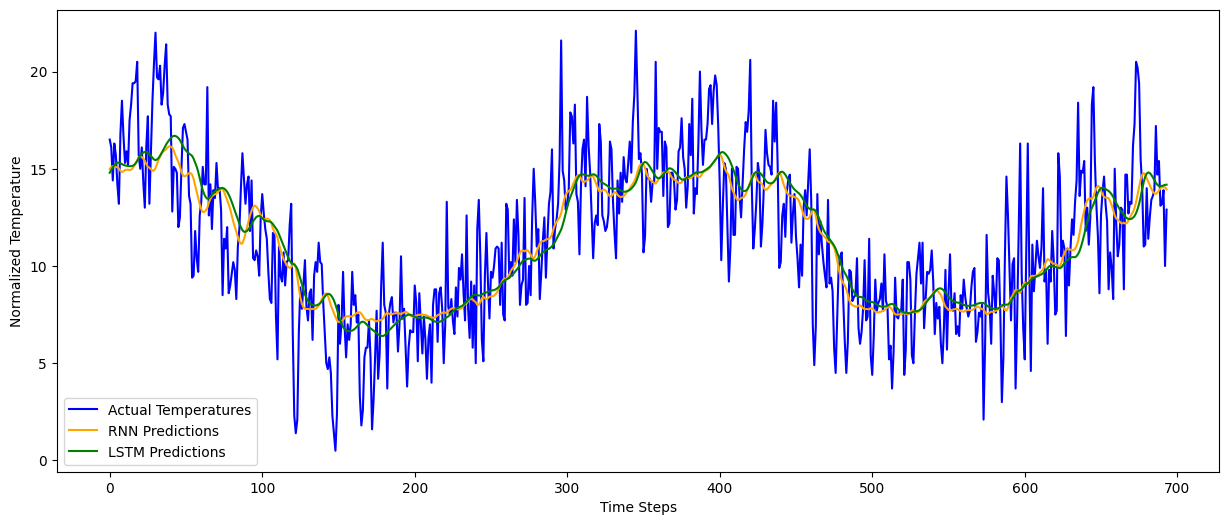

In [23]:
import matplotlib.pyplot as plt

time_axis = np.arange(len(targets_list))

plt.figure(figsize=(15,6))
plt.plot(time_axis, targets_list, label='Actual Temperatures', color='blue')
plt.plot(time_axis, rnn_preds_list, label='RNN Predictions', color='orange')
plt.plot(time_axis, lstm_preds_list, label='LSTM Predictions', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Temperature')
plt.legend()
plt.show()
